Siden dette datasettet i utgangspunktet har mange likheter med red wine datasette og jeg har analysert red-wine først kommer jeg til å bruke noen av analysene og kommentarene fra red-wine hvor det ikke er betydelige forskjellmellom datasettene.  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.metrics import silhouette_score, davies_bouldin_score, silhouette_samples
from imblearn.over_sampling import SMOTENC
import seaborn as sb

In [2]:
df = pd.read_csv("../Oblig2/winequality-white.csv", delimiter=";")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Hensikten med datasettet er å muliggjøre analyse og modellering av vin kvalitet ut ifra forskjellige målte kjemiske karaterestikker (features) som for eks. «fixed acidity», «citric acid», "alcohol" osv.
Datasettet inneholder en target kolonne, «quality». Kolonnen oppgir en vurdering av kvaliteten til en vin og skal være oppgitt med en int-verdi fra 1-10 [1].
Videre inneholder datasettet 11 kolonner med feature verdier som beskrive forskjellige målte kjemiske egenskaper den enkelte vinen har. Alle disse kolonnen har en verditype av float.

ref [1]: UCI Irvine. (u.å). Wine Quality. Hentet 12.10.2025 fra "https://archive.ics.uci.edu/dataset/186/wine+quality"

In [3]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [4]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Ut i fra seksjonene over så ser det ikke ut til at det er noen manglende verdier i datasettet.

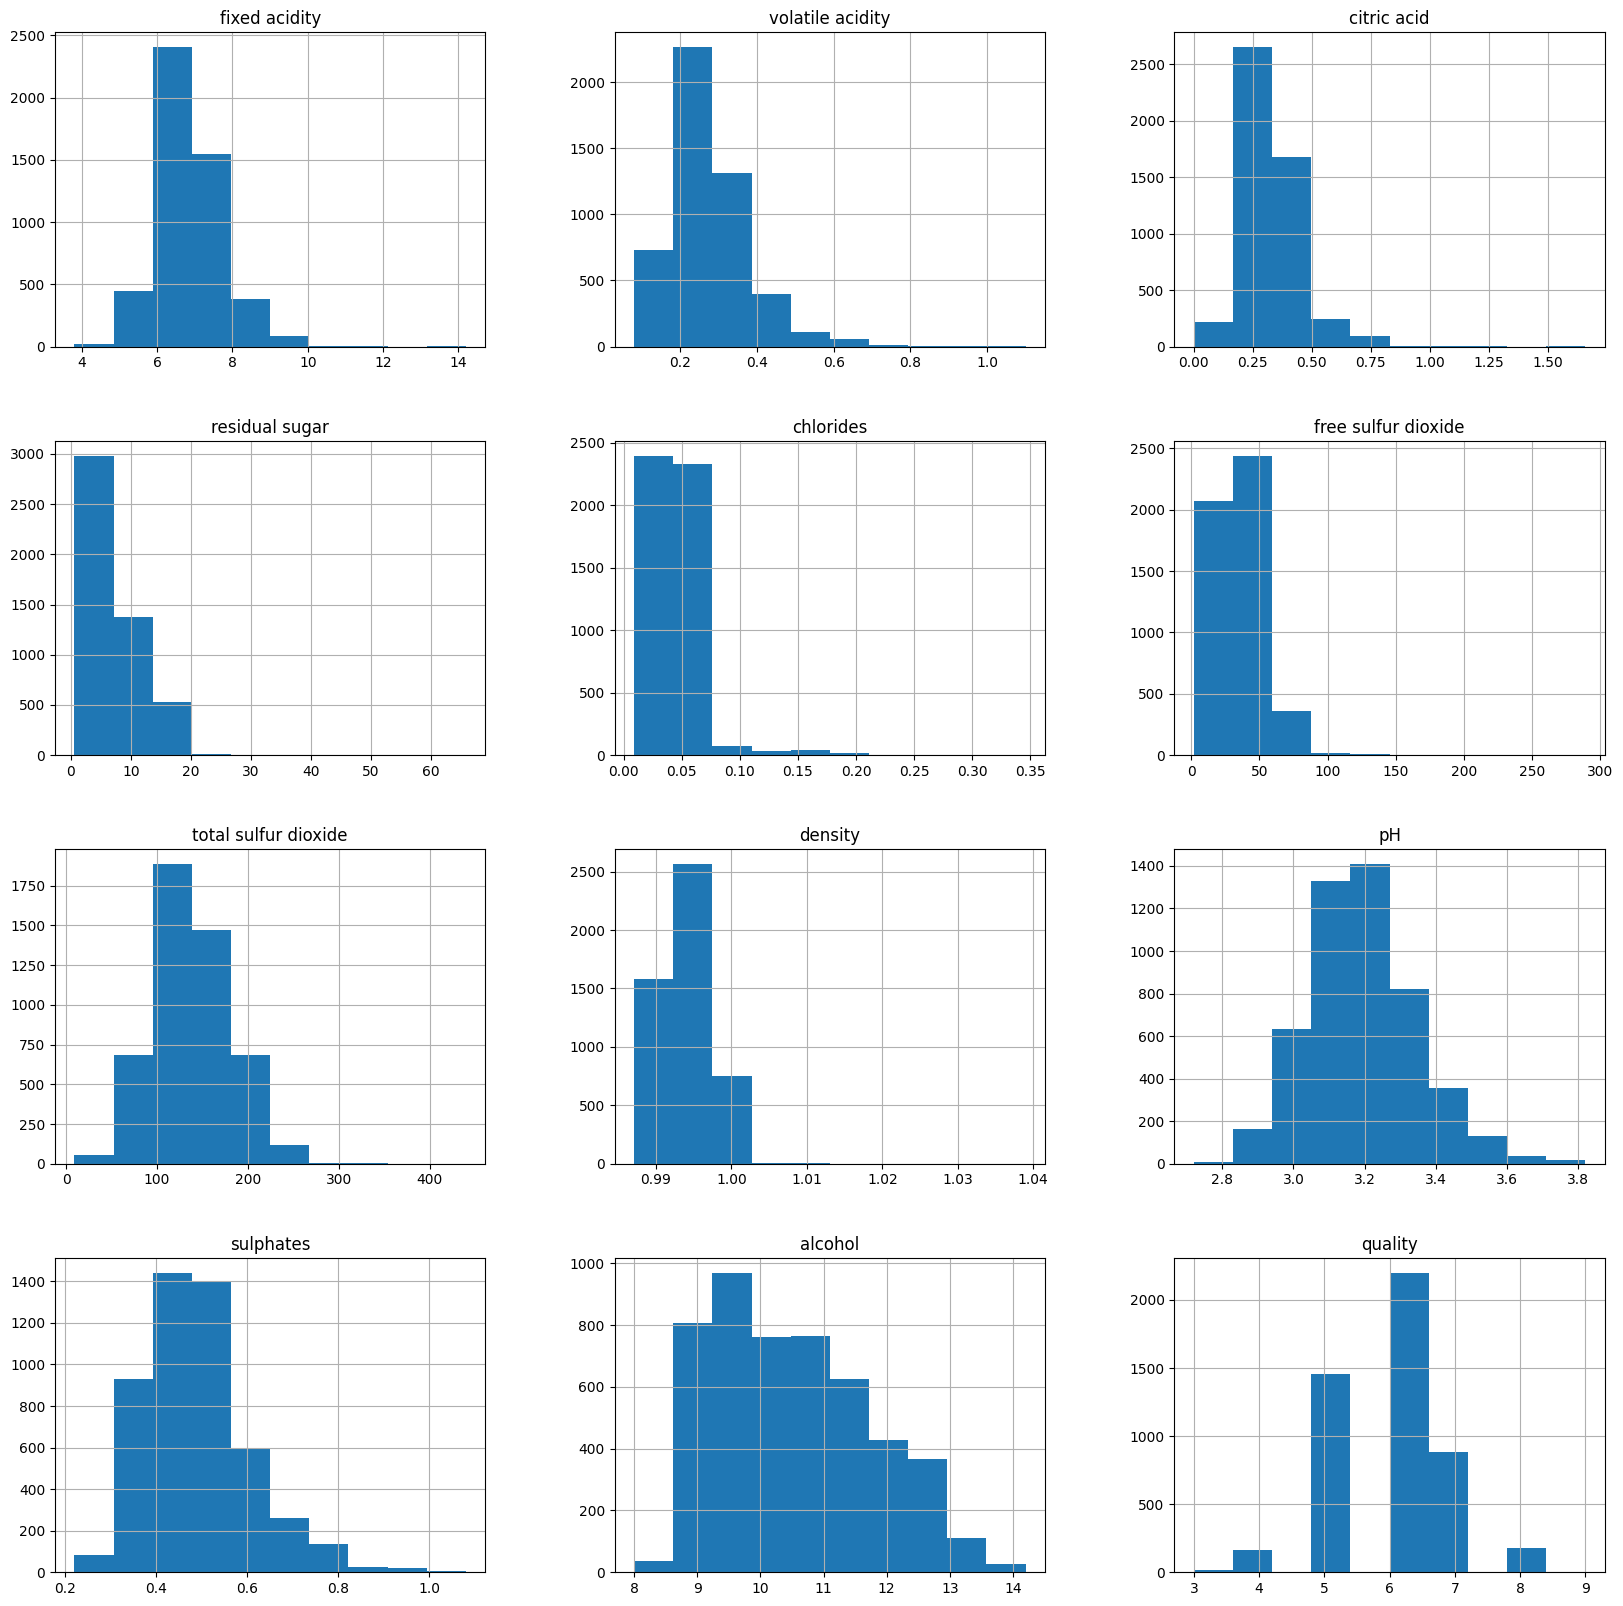

In [5]:
df.hist(figsize=(20,20))
plt.show()

Som vi ser ut i fra histogrammene i seksjonen over så ser datasettet i hovedsak ser ut til å være relativt normalfordelt eller ensidig normalfordelt. Det er imidlertid en betydelig forskjell i scaleringen til verdiene til de forskjellige featurene og det er dermed sansynelig at vi bør gjøre en vurdering i forhold scalering ved analysen av datasettet. 

I seksjonene under har jeg gjennomført en test scalering med MinMaxScaler, som vi ser ut i fra histogrammet etter denne scaleringen så x-verdiene nå fordelt i samme range mellom 0-1.

I den videre koden kommer jeg til å legge inn alternativ for scalering med både MinMaxScaler og StandardScaler, slik at begge disse kan testes ut ved trening av modelen.

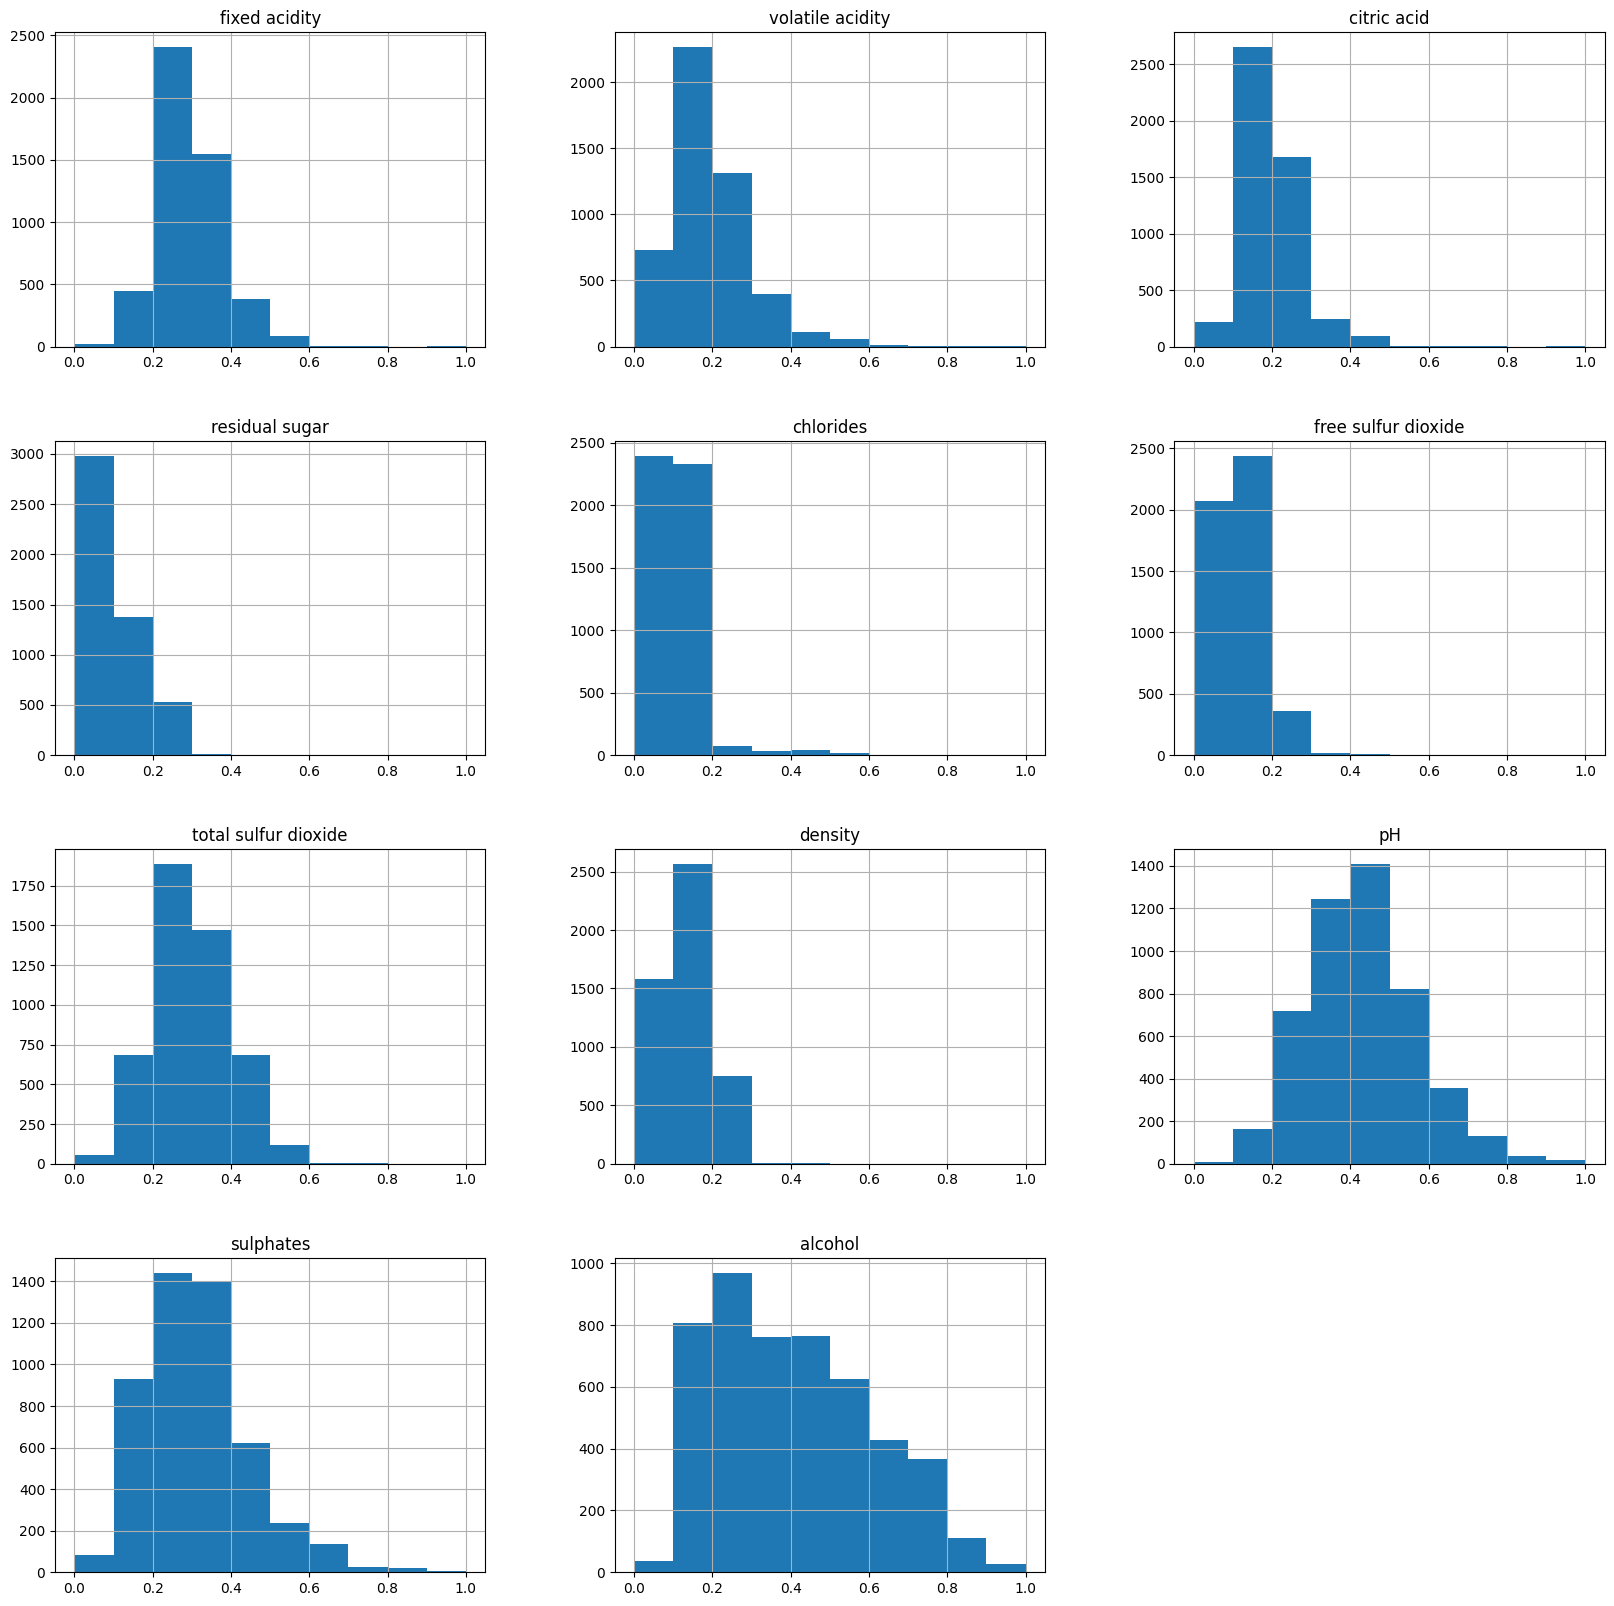

In [6]:
test_scaler = MinMaxScaler()
df_test_scaler = df.drop(columns='quality', axis=1)
test_scaler.fit(df_test_scaler)
df_test = pd.DataFrame(test_scaler.transform(df_test_scaler), columns=df_test_scaler.columns)
df_test.hist(figsize=(20,20))
plt.show()

quality
6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: count, dtype: int64


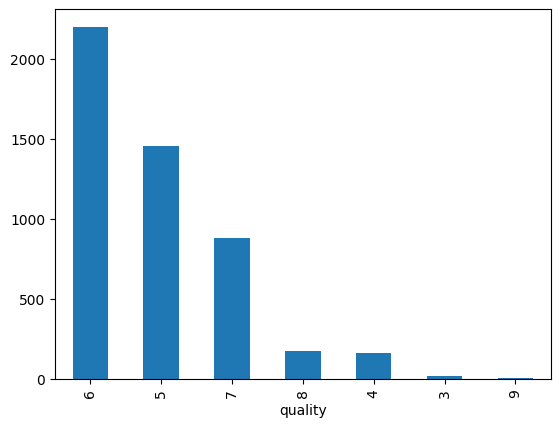

In [7]:
df['quality'].value_counts().plot.bar()
print(df['quality'].value_counts())

Basert på dataene i seksjonen over så ser vi tydelig at datasette har en betydelig skjevfordeling i target verdiene og at det er en over representasjon for verdier på 5 og 6, samt at det også er mange rader med verdi 7 i 'quality' kolonnen, mens det er veldig få verdier registrert for 9 og 3. Det er også betydelig færre verdier registrert for verdi 8 og 4 kontra 7, 5 og 6.

I dette datasettet er enda ferre verdier for den miste klassen i 'quality' kolonnen, dette gjør at det ikke er mulig å bruke upsamling med SMOTENC, så jeg velger for dette datasette å ikke gjøre noen videre behandling av datasettet med down eller upsamling siden jeg alt har gjort dette for red-wine datasettet.

I forhold til oppdeling av datasettet så kommer jeg til å bruke stratified sampling med en fordeling på 60, 20 ,20% til henholdsvis train, validation, test. Jeg har valgt denne spilten da jeg mener at dette vil gi den beste balansen mellom traing, validation og test data og fortsatt gi en verdi representasjon for kategori 9 for 'quality' kolonnen.

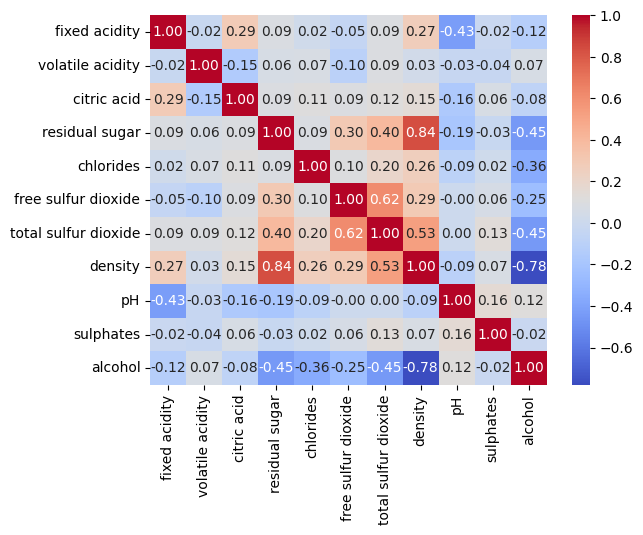

In [8]:
df_features = df.drop(columns='quality', axis=1)
matrix = df_features.corr()
sb.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

Som vi ser av heatmapen over så har vi to punkter som har noe høyere korrelsasjoner med 0.84 for density-residual sugar og -0.78 for density-alcohole. Selvom disse korrelasjonene begynner å bli noe høyere velger jeg ikke å gjøre noe videre behandling av disse. 

In [9]:
# funksjon for splitting av dataset, og downsampling for balanser
def split_dataset(data, down_s=0, up_s=False):
    train_val = data.groupby("quality", observed=False, group_keys=False)[data.columns].sample(frac=0.8)
    test = data.drop(train_val.index)
    train = train_val.groupby("quality", observed=False, group_keys=False)[train_val.columns].sample(frac=0.75)
    validation = train_val.drop(train.index)

    # funksjonalitet for down og upsampling som gjennomførers kun på train delen av datasette for å unngå overfiting.
    if(down_s > 0): train = downsampling(data, down_s)
    if(up_s): train, _ = SMOTENC('auto').fit_resample(train, train['quality'])
        
    return [train, validation, test]

def check_split_dataset(data):
    print(data[0]["quality"].value_counts()/data[0].shape[0])
    print(data[1]["quality"].value_counts()/data[1].shape[0])
    print(data[2]["quality"].value_counts()/data[2].shape[0])

def downsampling(data, n):
    df_3 = df[df['quality'] == 3]
    if(df_3['quality'].count() > n): df_3 = df_3.sample(n)

    df_4 = df[df['quality'] == 4]
    if(df_4['quality'].count() > n): df_4 = df_4.sample(n)

    df_5 = df[df['quality'] == 5]
    if(df_5['quality'].count() > n): df_5 = df_5.sample(n)

    df_6 = df[df['quality'] == 6]
    if(df_6['quality'].count() > n): df_6 = df_6.sample(n)

    df_7 = df[df['quality'] == 7]
    if(df_7['quality'].count() > n): df_7 = df_7.sample(n)

    df_8 = df[df['quality'] == 8]
    if(df_8['quality'].count() > n): df_8 = df_8.sample(n)
    
    df_down = pd.concat([df_3, df_4, df_5, df_6 , df_7, df_8])

    return df_down

def split_targets_and_features(data):
    targets = data.quality
    features = data.drop("quality", axis=1)

    return [features, targets]

def create_set_of_targets_and_features(data, min_max=False, mean=False):
    train = split_targets_and_features(data[0])
    validation = split_targets_and_features(data[1])
    test = split_targets_and_features(data[2])

    #funksjon for min_max normalisering av data
    if(min_max):
        scaler_min_max =MinMaxScaler()
        scaler_min_max.fit(train[0])
        train[0] = pd.DataFrame(scaler_min_max.transform(train[0]), columns=train[0].columns)
        validation[0] = pd.DataFrame(scaler_min_max.transform(validation[0]), columns=validation[0].columns)
        test[0] = pd.DataFrame(scaler_min_max.transform(test[0]), columns=test[0].columns)    
    
    # funksjon for mean normalisering av data
    if(mean):
        scaler_mean = StandardScaler()
        scaler_mean.fit(train[0])
        train[0] = pd.DataFrame(scaler_mean.transform(train[0]), columns=train[0].columns)
        validation[0] = pd.DataFrame(scaler_mean.transform(validation[0]), columns=validation[0].columns)
        test[0] = pd.DataFrame(scaler_mean.transform(test[0]), columns=test[0].columns)

    return [train, validation, test]

# hovedfunksjon for splitting av dataset med valgmulighet for normalisering
def create_full_dataset(input, min_max=False, mean=False, down_s=0, up_s=False):
    data = split_dataset(input, down_s=0 ,up_s=False)
    dataset = create_set_of_targets_and_features(data, min_max, mean)

    return dataset

In [10]:
def evaluate_model_external(true_labels, pred_labels):
    adjusted_rand = adjusted_rand_score(true_labels, pred_labels)
    homogeneity = homogeneity_score(true_labels, pred_labels)
    completeness = completeness_score(true_labels, pred_labels) 
    v_measure = v_measure_score(true_labels, pred_labels)

    return [adjusted_rand, homogeneity, completeness, v_measure]

def external_results_print(adjusted_rand, homogeneity, completeness, v_measure):
    print(f'Adjusted rand score: {np.mean(adjusted_rand):.2f} +- {np.std(adjusted_rand):.2f}')
    print(f'Homogeneity score: {np.mean(homogeneity):.2f} +- {np.std(homogeneity):.2f}')
    print(f'Completness score: {np.mean(completeness):.2f} +- {np.std(completeness):.2f}')
    print(f'V-measure score: {np.mean(v_measure):.2f} +- {np.std(v_measure):.2f}')

def evaluate_model_internal(data_features, pred_labels):
    silhouette = silhouette_score(data_features, pred_labels)
    davies = davies_bouldin_score(data_features, pred_labels)
    
    return [silhouette, davies]

def internal_results_print(silhouette, davies):
    print(f'Silhouette score: {np.mean(silhouette):.2f} +- {np.std(silhouette):.2f}')
    print(f'Davies score: {np.mean(davies):.2f} +- {np.std(davies):.2f}')

def append_values(results_external, results_internal, adjusted_rand, homogeneity, completeness, v_measure, silhouette, davies):
        adjusted_rand.append(results_external[0])
        homogeneity.append(results_external[1])
        completeness.append(results_external[2])
        v_measure.append(results_external[3])
        silhouette.append(results_internal[0])
        davies.append(results_internal[1])

def validate_kmeans(classifier, runs=1, test=False, min_max=False, mean=False, down_s=0 ,up_s=False, external=True):
    train_adjusted_rand, train_homogeneity, train_completeness, train_v_measure, train_silhouette, train_davies = [], [], [], [], [], []
    validate_adjusted_rand, validate_homogeneity, validate_completeness, validate_v_measure, validate_silhouette, validate_davies = [], [], [], [], [], []
    test_adjusted_rand, test_homogeneity, test_completeness, test_v_measure, test_silhouette, test_davies = [], [], [], [], [], []

    if(runs < 1): runs = 1

    for i in range(0, runs, 1):
        dataset = create_full_dataset(df)
        model = classifier.fit(dataset[0][0])
        pred_train = model.labels_
        pred_validate = model.predict(dataset[1][0])
        pred_test = model.predict(dataset[2][0])

        r_train_external = evaluate_model_external(dataset[0][1], pred_train)
        r_train_internal = evaluate_model_internal(dataset[0][0], pred_train)
        append_values(r_train_external, r_train_internal, train_adjusted_rand, train_homogeneity, train_completeness, 
                      train_v_measure, train_silhouette, train_davies)
        
        r_validate_external = evaluate_model_external(dataset[1][1], pred_validate)
        r_validate_internal = evaluate_model_internal(dataset[1][0], pred_validate)
        append_values(r_validate_external, r_validate_internal, validate_adjusted_rand, validate_homogeneity, validate_completeness, 
                      validate_v_measure, validate_silhouette, validate_davies)
        
        if(test):
            r_test_external = evaluate_model_external(dataset[2][1], pred_test)
            r_test_internal = evaluate_model_internal(dataset[2][0], pred_test)
            append_values(r_test_external, r_test_internal, test_adjusted_rand, test_homogeneity, test_completeness, 
                      test_v_measure, test_silhouette, test_davies)

    print('Traning ressults:')
    if(external):
        print('**********************************')
        print('External:')
        external_results_print(train_adjusted_rand, train_homogeneity, train_completeness, train_v_measure)
    if not(external):    
        print('**********************************')
        print("Internal:")
        internal_results_print(train_silhouette, train_davies)
    print('')
    print('Validation results:')
    if(external):
        print('**********************************')
        print('External:')
        external_results_print(validate_adjusted_rand, validate_homogeneity, validate_completeness, validate_v_measure)
    if not(external):
        print('**********************************')
        print('Internal:')
        internal_results_print(validate_silhouette, validate_davies)
    if(test):
        print('')
        print('Test results:')
        if(external):
            print('**********************************')
            print('External:')
            external_results_print(test_adjusted_rand, test_homogeneity, test_completeness, test_v_measure)
        if not(external):
            print('**********************************')
            print('Internal:')
            internal_results_print(test_silhouette, test_davies)

def validate_agglomerative(classifier, min_max=False, mean=False, external=True):
    adjusted_rand, homogeneity, completeness, v_measure, silhouette, davies = [], [], [], [], [], []
    dataset = split_targets_and_features(df)

    if(min_max):
        scaler_min_max = MinMaxScaler()
        scaler_min_max.fit(dataset[0])
        dataset[0] = pd.DataFrame(scaler_min_max.transform(dataset[0]), columns=dataset[0].columns)

    if(mean):
        scaler_mean = StandardScaler()
        scaler_mean.fit(dataset[0])
        dataset[0] = pd.DataFrame(scaler_mean.transform(dataset[0]), columns=dataset[0].columns)

    model = classifier.fit(dataset[0])
    pred_labels = model.labels_    

    r_external = evaluate_model_external(dataset[1], pred_labels)
    r_internal = evaluate_model_internal(dataset[0], pred_labels)
    append_values(r_external, r_internal, adjusted_rand, homogeneity, completeness, 
                    v_measure, silhouette, davies)

    print('Ressults:')
    if(external):
        print('**********************************')
        print('External:')
        external_results_print(adjusted_rand, homogeneity, completeness, v_measure)
    if not (external):
        print('**********************************')
        print("Internal:")
        internal_results_print(silhouette, davies)

def optimise_clusters(data, max_cluster):
    silhouette = []
    inertias = []
    n_clusters = range(2, max_cluster)
    data_features = data.drop(columns='quality', axis=1)
    for n in n_clusters:
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(data_features)

        inertias.append(kmeans.inertia_)
        silhouette.append(silhouette_score(data_features, kmeans.predict(data_features)))
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].set_ylabel("Inertias")
    ax[1].set_ylabel("Silhouette")
    ax[0].set_xlabel("Clusters")
    ax[1].set_xlabel("Clusters")
    ax[0].plot(n_clusters, inertias, "o-",)
    ax[1].plot(n_clusters, silhouette, "o-")

def silhouette_plot(data, max_clusters):
    fig, ax = plt.subplots(2,4, sharey=True, figsize=(20,5))
    n_clusters = range(2, max_clusters)
    for n in n_clusters:        
        kmeans = KMeans(n_clusters=n).fit(data)       
        predictions = kmeans.predict(data)        
        silhouette_average = silhouette_score(data, predictions)        
        silhouette_sample = silhouette_samples(data, predictions)        
        x_start = 0
        for i in range(n):           
            ith_cluster_samples = silhouette_sample[kmeans.labels_ == i]
            ith_cluster_samples.sort()            
            x_end = x_start + ith_cluster_samples.shape[0]            
            ax[(n-2)//4][(n-2)%4].fill_between(np.arange(x_start, x_end), 0, ith_cluster_samples)
            ax[(n-2)//4][(n-2)%4].plot([0,silhouette_sample.shape[0]],[silhouette_average, silhouette_average], '--', color='black')
            x_start = x_end 


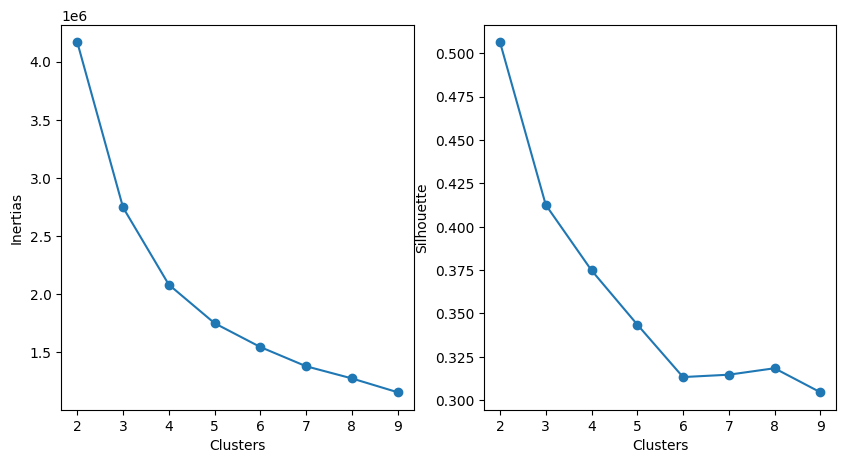

In [11]:
optimise_clusters(df, 10)

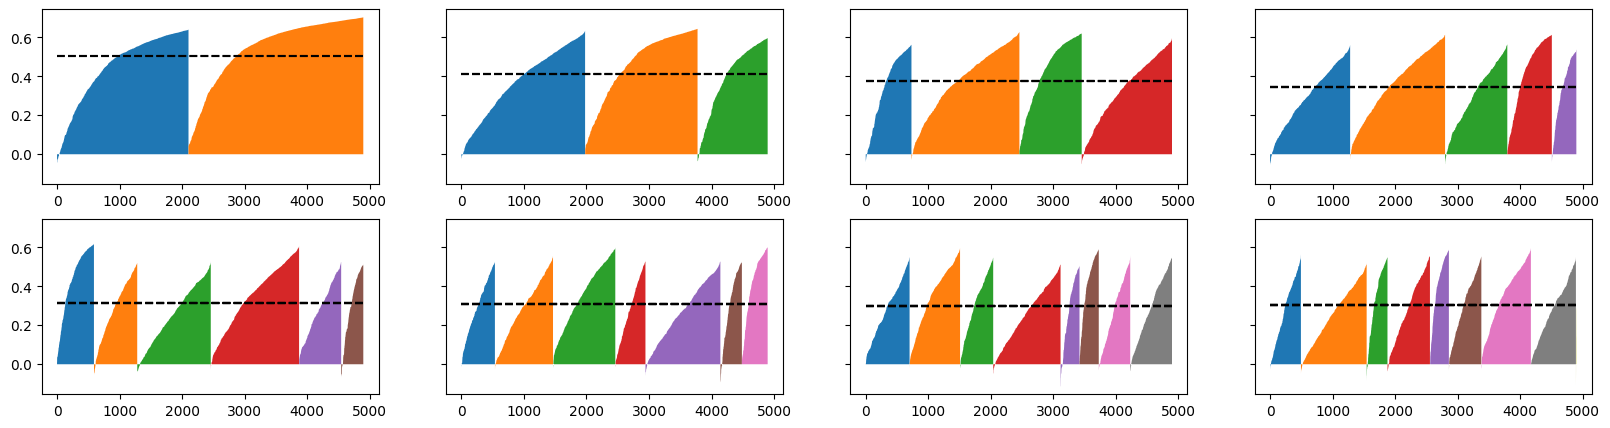

In [12]:
silhouette_plot(df, 10)

Før vi starter med selve testingen av clustering modelene for datasette så kjører vi en analyse med inertia og silhouette score ut i fra en k-means modell for å se om det er noen tydelige naturlig clustere uten om de target verdiene vi allerde har i datasettet. Ut i fra plotene for inertia så ser vi at inertia verdiene syker raskt når det legges til flere klustere, før reduksjonen i inertia flater ut etter hver som flere clustere legges til.
Vi ser også at verdiene for inertia er betydelig høyere enn for red-wine datasettet. For silhouette score, så ser vi at kurven synker raskt når det legges til flere klustere helt fram til 6 klustere, før den da flater ut og silhouette score verdien ikke endres like mye.
For cofficient plotet for silhouette score, så ser fordeling på 2 clustere er mye jevnere fordelt i størelse enn for red-wine datasette selvom selve scoren er lavere enn for red-wine.

Totaltsett peker dette på at target verdiene ikke i utgangspunkt gir god skille til å danne clustere, dette er ikke helt uventet da det er veldig forforskjellige i fordelingen til kategriene/verdiene og 'quality' kolonnen.

For testing av Kmeans modellen så kommer jeg til å splitte opp vurderingen i to hoveddeler med fokus på external vurdring for den ene del og internal for den andre delen. I utgangspunktet kommer jeg i hovedsak til å bruke antall clustere som tuning parameterm. Videre kommer jeg til å bruke valg muligher jeg har bygd inn i fuksjonene mine for å vurdere om bruk av forskjellige scalerings gir noe utbytte for modellen.

In [62]:
kmans = KMeans(n_clusters=7)
validate_kmeans(kmans, runs=5)

Traning ressults:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.04 +- 0.00
Completness score: 0.02 +- 0.00
V-measure score: 0.03 +- 0.00

Validation results:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.04 +- 0.00
Completness score: 0.03 +- 0.00
V-measure score: 0.03 +- 0.00


In [63]:
kmans = KMeans(n_clusters=6)
validate_kmeans(kmans, runs=5)

Traning ressults:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.03 +- 0.00
Completness score: 0.03 +- 0.00
V-measure score: 0.03 +- 0.00

Validation results:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.04 +- 0.01
Completness score: 0.03 +- 0.00
V-measure score: 0.03 +- 0.00


In [64]:
kmans = KMeans(n_clusters=5)
validate_kmeans(kmans, runs=5)

Traning ressults:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.03 +- 0.00
Completness score: 0.03 +- 0.00
V-measure score: 0.03 +- 0.00

Validation results:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.04 +- 0.01
Completness score: 0.03 +- 0.00
V-measure score: 0.03 +- 0.01


In [65]:
kmans = KMeans(n_clusters=4)
validate_kmeans(kmans, runs=5)

Traning ressults:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.03 +- 0.00
Completness score: 0.02 +- 0.00
V-measure score: 0.03 +- 0.00

Validation results:
**********************************
External:
Adjusted rand score: 0.01 +- 0.01
Homogeneity score: 0.03 +- 0.00
Completness score: 0.03 +- 0.00
V-measure score: 0.03 +- 0.00


In [66]:
kmans = KMeans(n_clusters=8)
validate_kmeans(kmans, runs=5)

Traning ressults:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.04 +- 0.00
Completness score: 0.02 +- 0.00
V-measure score: 0.03 +- 0.00

Validation results:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.05 +- 0.00
Completness score: 0.03 +- 0.00
V-measure score: 0.04 +- 0.00


In [67]:
kmans = KMeans(n_clusters=9)
validate_kmeans(kmans, runs=5)

Traning ressults:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.04 +- 0.00
Completness score: 0.03 +- 0.00
V-measure score: 0.03 +- 0.00

Validation results:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.05 +- 0.01
Completness score: 0.03 +- 0.00
V-measure score: 0.04 +- 0.00


In [68]:
kmans = KMeans(n_clusters=7)
validate_kmeans(kmans, runs=5, min_max=True)

Traning ressults:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.04 +- 0.00
Completness score: 0.03 +- 0.00
V-measure score: 0.03 +- 0.00

Validation results:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.05 +- 0.01
Completness score: 0.03 +- 0.00
V-measure score: 0.04 +- 0.00


In [69]:
kmans = KMeans(n_clusters=6)
validate_kmeans(kmans, runs=5, min_max=True)

Traning ressults:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.03 +- 0.00
Completness score: 0.03 +- 0.00
V-measure score: 0.03 +- 0.00

Validation results:
**********************************
External:
Adjusted rand score: 0.01 +- 0.01
Homogeneity score: 0.04 +- 0.01
Completness score: 0.03 +- 0.01
V-measure score: 0.04 +- 0.01


In [70]:
kmans = KMeans(n_clusters=8)
validate_kmeans(kmans, runs=5, min_max=True)

Traning ressults:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.04 +- 0.00
Completness score: 0.03 +- 0.00
V-measure score: 0.03 +- 0.00

Validation results:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.06 +- 0.01
Completness score: 0.04 +- 0.00
V-measure score: 0.04 +- 0.01


In [71]:
kmans = KMeans(n_clusters=7)
validate_kmeans(kmans, runs=5, mean=True)

Traning ressults:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.04 +- 0.00
Completness score: 0.02 +- 0.00
V-measure score: 0.03 +- 0.00

Validation results:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.04 +- 0.01
Completness score: 0.03 +- 0.01
V-measure score: 0.04 +- 0.01


In [72]:
kmans = KMeans(n_clusters=6)
validate_kmeans(kmans, runs=5, mean=True)

Traning ressults:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.03 +- 0.00
Completness score: 0.03 +- 0.00
V-measure score: 0.03 +- 0.00

Validation results:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.04 +- 0.00
Completness score: 0.03 +- 0.00
V-measure score: 0.03 +- 0.00


In [74]:
kmans = KMeans(n_clusters=8)
validate_kmeans(kmans, runs=5, mean=True)

Traning ressults:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.04 +- 0.00
Completness score: 0.03 +- 0.00
V-measure score: 0.03 +- 0.00

Validation results:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.05 +- 0.00
Completness score: 0.03 +- 0.00
V-measure score: 0.04 +- 0.00


In [83]:
kmans = KMeans(n_clusters=8)
validate_kmeans(kmans, runs=20, test=True, min_max=True)

Traning ressults:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.04 +- 0.00
Completness score: 0.03 +- 0.00
V-measure score: 0.03 +- 0.00

Validation results:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.05 +- 0.01
Completness score: 0.03 +- 0.01
V-measure score: 0.04 +- 0.01

Test results:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.05 +- 0.01
Completness score: 0.03 +- 0.00
V-measure score: 0.04 +- 0.01


Som vi ser av resultatene over for testing av K-means modellen over så er det vansklig å få denne modellen til prestere bra med dette datasette i forhold til external vurdering og det er i realiteten ingen betydelig forskjell mellom noen parameterene som har blitt tunet. Jeg har valgt å bruke modellen med 8 cluster og min_max scalering som det "beste" resultatet, men det har i realiteten ingen stor betydning ut i fra forskjellene i resultatene.

In [26]:
kmans = KMeans(n_clusters=2)
validate_kmeans(kmans, runs=5, external=False)

Traning ressults:
**********************************
Internal:
Silhouette score: 0.51 +- 0.00
Davies score: 0.70 +- 0.01

Validation results:
**********************************
Internal:
Silhouette score: 0.50 +- 0.01
Davies score: 0.70 +- 0.01


In [76]:
kmans = KMeans(n_clusters=3)
validate_kmeans(kmans, runs=5, external=False)

Traning ressults:
**********************************
Internal:
Silhouette score: 0.41 +- 0.00
Davies score: 0.78 +- 0.00

Validation results:
**********************************
Internal:
Silhouette score: 0.41 +- 0.00
Davies score: 0.79 +- 0.01


In [28]:
kmans = KMeans(n_clusters=4)
validate_kmeans(kmans, runs=5, external=False)

Traning ressults:
**********************************
Internal:
Silhouette score: 0.38 +- 0.00
Davies score: 0.84 +- 0.01

Validation results:
**********************************
Internal:
Silhouette score: 0.37 +- 0.01
Davies score: 0.84 +- 0.01


In [29]:
kmans = KMeans(n_clusters=5)
validate_kmeans(kmans, runs=5, external=False)

Traning ressults:
**********************************
Internal:
Silhouette score: 0.35 +- 0.00
Davies score: 0.90 +- 0.01

Validation results:
**********************************
Internal:
Silhouette score: 0.34 +- 0.01
Davies score: 0.91 +- 0.01


In [30]:
kmans = KMeans(n_clusters=6)
validate_kmeans(kmans, runs=5, external=False)

Traning ressults:
**********************************
Internal:
Silhouette score: 0.33 +- 0.01
Davies score: 0.92 +- 0.08

Validation results:
**********************************
Internal:
Silhouette score: 0.32 +- 0.01
Davies score: 0.96 +- 0.03


In [31]:
kmans = KMeans(n_clusters=7)
validate_kmeans(kmans, runs=5, external=False)

Traning ressults:
**********************************
Internal:
Silhouette score: 0.32 +- 0.00
Davies score: 0.96 +- 0.01

Validation results:
**********************************
Internal:
Silhouette score: 0.31 +- 0.01
Davies score: 0.97 +- 0.02


In [32]:
kmans = KMeans(n_clusters=8)
validate_kmeans(kmans, runs=5, external=False)

Traning ressults:
**********************************
Internal:
Silhouette score: 0.31 +- 0.00
Davies score: 0.95 +- 0.05

Validation results:
**********************************
Internal:
Silhouette score: 0.30 +- 0.01
Davies score: 0.99 +- 0.02


In [33]:
kmans = KMeans(n_clusters=2)
validate_kmeans(kmans, runs=5, external=False, min_max=True)

Traning ressults:
**********************************
Internal:
Silhouette score: 0.51 +- 0.00
Davies score: 0.70 +- 0.01

Validation results:
**********************************
Internal:
Silhouette score: 0.51 +- 0.01
Davies score: 0.69 +- 0.01


In [34]:
kmans = KMeans(n_clusters=2)
validate_kmeans(kmans, runs=5, external=False, mean=True)

Traning ressults:
**********************************
Internal:
Silhouette score: 0.51 +- 0.00
Davies score: 0.70 +- 0.00

Validation results:
**********************************
Internal:
Silhouette score: 0.51 +- 0.01
Davies score: 0.70 +- 0.01


In [77]:
kmans = KMeans(n_clusters=3)
validate_kmeans(kmans, runs=5, external=False, mean=True)

Traning ressults:
**********************************
Internal:
Silhouette score: 0.41 +- 0.00
Davies score: 0.78 +- 0.01

Validation results:
**********************************
Internal:
Silhouette score: 0.41 +- 0.00
Davies score: 0.79 +- 0.01


In [78]:
kmans = KMeans(n_clusters=5)
validate_kmeans(kmans, runs=5, external=False, mean=True)

Traning ressults:
**********************************
Internal:
Silhouette score: 0.34 +- 0.01
Davies score: 0.91 +- 0.01

Validation results:
**********************************
Internal:
Silhouette score: 0.34 +- 0.01
Davies score: 0.91 +- 0.01


In [79]:
kmans = KMeans(n_clusters=3)
validate_kmeans(kmans, runs=5, external=False, min_max=True)

Traning ressults:
**********************************
Internal:
Silhouette score: 0.41 +- 0.00
Davies score: 0.79 +- 0.00

Validation results:
**********************************
Internal:
Silhouette score: 0.42 +- 0.01
Davies score: 0.78 +- 0.01


In [80]:
kmans = KMeans(n_clusters=4)
validate_kmeans(kmans, runs=5, external=False, min_max=True)

Traning ressults:
**********************************
Internal:
Silhouette score: 0.37 +- 0.01
Davies score: 0.84 +- 0.01

Validation results:
**********************************
Internal:
Silhouette score: 0.37 +- 0.01
Davies score: 0.84 +- 0.01


In [81]:
kmans = KMeans(n_clusters=2)
validate_kmeans(kmans, runs=20, external=False)

Traning ressults:
**********************************
Internal:
Silhouette score: 0.51 +- 0.00
Davies score: 0.70 +- 0.00

Validation results:
**********************************
Internal:
Silhouette score: 0.51 +- 0.01
Davies score: 0.70 +- 0.01


For internal vurdering for denne k-means modellen så ser vi at det er 2 clustere som gir best resultat, men det er mye som tyder på at denne delingen heller ikke er optimal og de featurene vi har ikke gir noe gode muligheter til å dele opp forskjellige clustere. Det gir heller ikke noen uttelling å scalere verdiene til featurene i datasettet.

For testing og vurdering av Agglomerativ Clustering kommer jeg til å bruke antall clustere og linkage type til å tune modellen, jeg kommer også til å sjekke om min_max og mean scalering gir noe forbedring i resultatet.

Jeg kommer også Agglomertiv clustering å dele opp vurderingen for external og internal.

In [41]:
agg = AgglomerativeClustering(n_clusters=6, linkage="ward")
validate_agglomerative(agg)

Ressults:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.03 +- 0.00
Completness score: 0.03 +- 0.00
V-measure score: 0.03 +- 0.00


In [42]:
agg = AgglomerativeClustering(n_clusters=6, linkage="ward")
validate_agglomerative(agg, mean=True)

Ressults:
**********************************
External:
Adjusted rand score: 0.03 +- 0.00
Homogeneity score: 0.05 +- 0.00
Completness score: 0.04 +- 0.00
V-measure score: 0.05 +- 0.00


In [43]:
agg = AgglomerativeClustering(n_clusters=6, linkage="ward")
validate_agglomerative(agg, min_max=True)

Ressults:
**********************************
External:
Adjusted rand score: 0.04 +- 0.00
Homogeneity score: 0.07 +- 0.00
Completness score: 0.06 +- 0.00
V-measure score: 0.06 +- 0.00


In [44]:
agg = AgglomerativeClustering(n_clusters=6, linkage="complete")
validate_agglomerative(agg, min_max=True)

Ressults:
**********************************
External:
Adjusted rand score: 0.06 +- 0.00
Homogeneity score: 0.06 +- 0.00
Completness score: 0.09 +- 0.00
V-measure score: 0.07 +- 0.00


In [45]:
agg = AgglomerativeClustering(n_clusters=6, linkage="single")
validate_agglomerative(agg, min_max=True)

Ressults:
**********************************
External:
Adjusted rand score: -0.00 +- 0.00
Homogeneity score: 0.00 +- 0.00
Completness score: 0.18 +- 0.00
V-measure score: 0.00 +- 0.00


In [46]:
agg = AgglomerativeClustering(n_clusters=6, linkage="average")
validate_agglomerative(agg, min_max=True)

Ressults:
**********************************
External:
Adjusted rand score: 0.00 +- 0.00
Homogeneity score: 0.00 +- 0.00
Completness score: 0.24 +- 0.00
V-measure score: 0.01 +- 0.00


In [47]:
agg = AgglomerativeClustering(n_clusters=5, linkage="ward")
validate_agglomerative(agg, min_max=True)

Ressults:
**********************************
External:
Adjusted rand score: 0.04 +- 0.00
Homogeneity score: 0.07 +- 0.00
Completness score: 0.06 +- 0.00
V-measure score: 0.07 +- 0.00


In [48]:
agg = AgglomerativeClustering(n_clusters=4, linkage="ward")
validate_agglomerative(agg, min_max=True)

Ressults:
**********************************
External:
Adjusted rand score: 0.07 +- 0.00
Homogeneity score: 0.07 +- 0.00
Completness score: 0.07 +- 0.00
V-measure score: 0.07 +- 0.00


In [49]:
agg = AgglomerativeClustering(n_clusters=7, linkage="ward")
validate_agglomerative(agg, min_max=True)

Ressults:
**********************************
External:
Adjusted rand score: 0.04 +- 0.00
Homogeneity score: 0.08 +- 0.00
Completness score: 0.06 +- 0.00
V-measure score: 0.07 +- 0.00


In [50]:
agg = AgglomerativeClustering(n_clusters=8, linkage="ward")
validate_agglomerative(agg, min_max=True)

Ressults:
**********************************
External:
Adjusted rand score: 0.04 +- 0.00
Homogeneity score: 0.08 +- 0.00
Completness score: 0.05 +- 0.00
V-measure score: 0.06 +- 0.00


Som vi ser av resultatene for external vurdering for Agglomerativ clustering så prestere denne noe bedre enn k-means
(se kopi av verdiene). I forhold til forbedring av modellen så var det kun scaling av feature verdiene som ga postiv uttelling og min_mix scaling ga best resultater.

For dette datasette så var det Agglomerativ clustering som presterte best når vi vurderte prestasjonen ut i fra en external vurdering opp mot 'quality' kolonnen i datasettet. Som vi ser av verdiene under, så får Agglomerativ bedre resultat for alle verdiene selv om prestasjonen til modellen for dette datasettet fortsatt ikke er veldig god.

Totalsett ser vi at den beste modellen for agglomerativ clustering har noe bedre adjusted rand score som forteller at denne har bedre presisjon for klasifiseringen som gjøres, videre viser homogenity score at modellen er noe bedre til å få clusterene til å innehold ferre forskjellige klasser for target verdiene. Mens completeness score vider viser at modellen er litt bedre til å hold alle medlemmene av en gitt klasse satt til samme cluster.
V-measure er en samling av homogeneity og completness, dvs. hvis en av disse verdiene får veldig bra resultat, mens den andre for veldig dårlig så balansere v-measure ut dette.

kmans = KMeans(n_clusters=6)
validate_kmeans(kmans, test=True, runs=20, mean=True)
Traning ressults:
**********************************
External:
Adjusted rand score: -0.00 +- 0.00
Homogeneity score: 0.05 +- 0.01
Completness score: 0.04 +- 0.01
V-measure score: 0.04 +- 0.01

Validation results:
**********************************
External:
Adjusted rand score: -0.00 +- 0.01
Homogeneity score: 0.06 +- 0.01
Completness score: 0.05 +- 0.01
V-measure score: 0.06 +- 0.01

Test results:
**********************************
External:
Adjusted rand score: -0.00 +- 0.01
Homogeneity score: 0.07 +- 0.01
Completness score: 0.06 +- 0.01
V-measure score: 0.06 +- 0.01


agg = AgglomerativeClustering(n_clusters=6, linkage="ward")
validate_agglomerative(agg, min_max=True)
Ressults:
**********************************
External:
Adjusted rand score: 0.08 +- 0.00
Homogeneity score: 0.14 +- 0.00
Completness score: 0.10 +- 0.00
V-measure score: 0.12 +- 0.00

In [51]:
agg = AgglomerativeClustering(n_clusters=2, linkage="ward")
validate_agglomerative(agg, external=False)

Ressults:
**********************************
Internal:
Silhouette score: 0.50 +- 0.00
Davies score: 0.71 +- 0.00


In [52]:
agg = AgglomerativeClustering(n_clusters=3, linkage="ward")
validate_agglomerative(agg, external=False)

Ressults:
**********************************
Internal:
Silhouette score: 0.35 +- 0.00
Davies score: 0.84 +- 0.00


In [53]:
agg = AgglomerativeClustering(n_clusters=4, linkage="ward")
validate_agglomerative(agg, external=False)

Ressults:
**********************************
Internal:
Silhouette score: 0.32 +- 0.00
Davies score: 0.94 +- 0.00


In [54]:
agg = AgglomerativeClustering(n_clusters=5, linkage="ward")
validate_agglomerative(agg, external=False)

Ressults:
**********************************
Internal:
Silhouette score: 0.29 +- 0.00
Davies score: 0.94 +- 0.00


In [55]:
agg = AgglomerativeClustering(n_clusters=2, linkage="ward")
validate_agglomerative(agg, external=False, mean=True)

Ressults:
**********************************
Internal:
Silhouette score: 0.18 +- 0.00
Davies score: 2.00 +- 0.00


In [56]:
agg = AgglomerativeClustering(n_clusters=2, linkage="ward")
validate_agglomerative(agg, external=False, min_max=True)

Ressults:
**********************************
Internal:
Silhouette score: 0.19 +- 0.00
Davies score: 1.78 +- 0.00


In [57]:
agg = AgglomerativeClustering(n_clusters=2, linkage="ward")
validate_agglomerative(agg, external=False)

Ressults:
**********************************
Internal:
Silhouette score: 0.50 +- 0.00
Davies score: 0.71 +- 0.00


In [58]:
agg = AgglomerativeClustering(n_clusters=2, linkage="single")
validate_agglomerative(agg, external=False)

Ressults:
**********************************
Internal:
Silhouette score: 0.86 +- 0.00
Davies score: 0.10 +- 0.00


In [59]:
agg = AgglomerativeClustering(n_clusters=2, linkage="complete")
validate_agglomerative(agg, external=False)

Ressults:
**********************************
Internal:
Silhouette score: 0.47 +- 0.00
Davies score: 0.56 +- 0.00


In [60]:
agg = AgglomerativeClustering(n_clusters=2, linkage="average")
validate_agglomerative(agg, external=False)

Ressults:
**********************************
Internal:
Silhouette score: 0.86 +- 0.00
Davies score: 0.10 +- 0.00


Som vi ser av resultatene for denne modellen så gir det best resultater med 2 clustere og linkage = average, singel, complete (likt resultat for disse) for agglomerativ clustering modellen ved internal vurdering. Denne modellen prestere også bedre enn k-means modellen (se verdiene under). For k-means så var det også 2 clustere som ga best resultat ved internal vurdering. 

Når vi sammenligner resultatene så ser vi at agglomerativ fikk en silhouette score på 0.83 kontra 0.60 for k-means, dette betyr i praksis at median avstanden fra verdiene i clusterene til senturm av clusteret er mindre enn median avstanden til sentrum i andre clustere.

For Davies score fikk agglomerativ en verdi på 0.14 kontra en verdi på 0.62, dette betyr agglomerativ har oppnår bedre sepparasjon mellom clusterene enn k-means oppnår.

kmans = KMeans(n_clusters=2)
validate_kmeans(kmans, runs=20, external=False, test=True, mean=True)
Traning ressults:
**********************************
Internal:
Silhouette score: 0.61 +- 0.01
Davies score: 0.61 +- 0.01

Validation results:
**********************************
Internal:
Silhouette score: 0.60 +- 0.01
Davies score: 0.62 +- 0.02

Test results:
**********************************
Internal:
Silhouette score: 0.60 +- 0.02
Davies score: 0.62 +- 0.03


agg = AgglomerativeClustering(n_clusters=2, linkage="average"), single og complete ga også samme resultat.
validate_agglomerative(agg, external=False)
Ressults:
**********************************
Internal:
Silhouette score: 0.83 +- 0.00
Davies score: 0.14 +- 0.00

Totaltsett ga agglomerativ clustering best resultat for både external og internal vurdering, men det er viktig å påpeke at denne modellen i utgangspunktet ikke kan brukes til å direkte predikering av verdier for andre datasette eller nye verdier. Siden du ikke direkte kan bruke denne modellen til å predikere verdier for andre datasett så har du heller ingen mulighet til å gardere deg mot overfitting siden du ikke får testet eller validert modellen med andre datasett enn det du trener modellen på.

Hvis vi ser på helheten av vurderingwn for clustering av dette datasettet så ser vi at det ikke er noen god prestasjon ved external vurdering, men vi ser at det er noe bedre resultat ved interval vurdering, samt at vi bruker naturlig clustere i datasette kontra target verdiene som er oppgitt. Dette er godt mulig at skyldes at du har veldig ujevn fordeling av target verdiene og at det veldig høy representasjon for 2 av kategoriene for disse verdiene.